## The topic we choose is Project 7: "Adapation to new classes" <br>
### Linfeng Ye, Bowen Zhang, Kejian Zhu

## Contribution
Linfeng Ye: With Bowen Zhang together determines the framework of the ScatterCNN, implementing the ScatterCNN <br>
Bowen Zhang: With Linfeng Ye together determines the framework of the ScatterCNN, documenting the result of the notebook, experiment with other CNN structure that is beaten by the accuracy of scatterCNN<br>
Kejian Zhu: Implementing extra methods for unsupervised learning, restructure codes to perform training on different unseen classes,  experiment with pure GMM that is beaten by the accuracy of scatterCNN<br><br>
All of us spent much time searching for and reading papers that related to unsupervised image classification and discussed possible algorithms that could be tested and compared for our task.

In [5]:
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from kymatio.torch import Scattering2D
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import *
import warnings
from sklearn.mixture import GaussianMixture
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
from matplotlib import pyplot as plt
import seaborn as sns;

In this document, we experiment to use CNN, more specifically scattering CNN to perform unsupervised learning to predict unseen classes labels. The dataset used here is cifar. <br>
We mainly follows the method that is discussed in this paper: https://arxiv.org/abs/1809.06367

Our objevtive is to build a model such that it can detect K+N labels using unsupervised method after building training a model with K labels in a supervised method.

The project contains two parts:

1. Perform supervised training on K labels:

<pre>In our case, we experimented with ScatteringNet and CNN to perform supervised training on K labels.During supervised learning, we want our model to capture the features of the input image instead of memorizing them. The ability of our model to identify the features of the image is important for clustering unseen labels. 

During the training procedure, we treat any input image with class labels not in existing K labels as 1 single class. For example, when K = 5, and all the images with corresponding label not in the set of 5 labels will be grouped into a new class as our 6th label. Hence, during training, when given K class labels, the model's final layer will have dimension K + 1.

</pre>


2. Perfom unsupervised training on the new N labels, meanwhile combining the output model from step 1.

<pre>In our case, we used Gaussian Mixture Model to perform unsupervised training on the new N labels.

From step 1, we have built a model to detect the existing K class labels from unseen labels. In this step, we use GMM to cluster all the images classified as "unseen label" into N different clusters.
</pre>

### Part I: Train CNN to learn the existing K labels ###

Step 1: Define the dataset for N unseen classes. <br>
<pre> get_images select all the images with labels in the predefined unseen classes list. <br>
 UnLabel_Dataset returns the dataset with labels of unseen classes removed.

In [6]:
class UnLabel_Dataset(Dataset):
    """
    UnLabel_Dataset: define a Dataset for unlabeled data
    """
    def __init__(self, imgs, ground_truth, transform):
        """
        input -> imgs: all images in the dataset
                 ground_truth: the ground truth of each image
                 transform: transform, could be None
        """
        self.imgs = imgs
        self.ground_truth = ground_truth
        self.transform = transform
    def __len__(self):
        return len(self.ground_truth)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        tar = self.ground_truth[idx]
        if self.transform:
            img = self.transform(img)
        return img[None:], tar

In [7]:
class get_img():
    def __init__(self, classes=[]):
        """
        input -> classes: classes will be replaced.
        """
        self.classes = classes
    def __call__(self, dataset):
        tensor_targets = torch.tensor(dataset.targets)
        semasks = torch.any(torch.stack( [torch.eq(tensor_targets, aelem).logical_or_(torch.eq(tensor_targets, aelem)) for aelem in self.classes], dim=0), dim = 0)
        imgs = dataset.data[semasks]
        tars = torch.tensor(dataset.targets)[semasks.tolist()].tolist()
        return imgs, tars

Step 2: Convert the new N labeled images as unlabeled dataset

In [8]:
class replace_label():
    def __init__(self, labels=[], tar_label=7):
        """
        input -> labels: the labels(classed) will be replaced.
                 tar_label: the labels in 'labels' will be replaced by tar_label in __call__()
        """
        super(replace_label, self).__init__()
        if len(labels)!=NUM_UNTARGET_CLASS:
            warnings.warn('Length of labels neq to NUM_UNTARGET_CLASS!')
        self.labels = labels
        self.tar_label = tar_label
    def __call__(self, labels):
        labels_cpy = torch.clone(labels)
        semasks = torch.any(torch.stack([torch.eq(labels, aelem).logical_or_(torch.eq(labels, aelem)) for aelem in self.labels], dim=0), dim = 0)
        labels_cpy[semasks] = self.tar_label
        return labels_cpy

Step 3: Define Model Structure 

In [9]:
class ScatterCNN(nn.Module):
    def __init__(self, classes=10, **kwargs):
        super(ScatterCNN, self).__init__()
        self.norm0 = nn.BatchNorm2d(3*81)
        self.Conv0 = nn.Conv2d(3*81, 256, kernel_size=1, stride=1)
        self.norm1 = nn.BatchNorm2d(256)
        self.prelu1 = nn.PReLU()
        self.Conv1 = nn.Conv2d(256, 128, kernel_size=3, stride=1)
        self.norm2 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.Conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.prelu2 = nn.PReLU()
        self.fc = nn.Linear(64*1, classes)
    def feature(self, x):
        x = x.view(-1, 3 * 81, 8, 8)
        x = self.norm0(x)
        x_ = self.Conv0(x)
        x = self.norm1(x_)
        x = self.prelu1(x)
        x = self.Conv1(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.Conv2(x)
        x = self.norm3(x)
        x = self.prelu2(x)
        x = x.reshape(x.size(0), -1)
        return x
    
    def forward(self, x):
        x = self.feature(x)
        x = self.fc(x)
        return x

Step 4: Perform supervised training on our CNN while monitoring the test performance

In [10]:
def train(model, train_loader, optimizer, replace, scattering):
    model = model.to(device)
    model.train()
    num_examples = 0
    correct = 0
    train_loss = 0
    for data, target in tqdm(train_loader):
        target = replace(target)
        data, target = data.to(device), target.to(device)
        output = model(scattering(data))
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += F.cross_entropy(output, target, reduction='sum').item()
        num_examples += len(data)

    train_loss /= num_examples
    train_acc = 100. * correct / num_examples
    print(f'Train set: Average loss: {train_loss:.4f}, '
          f'Accuracy: {correct}/{num_examples} ({train_acc:.2f}%)')
    return train_loss, train_acc

In [11]:
def test(model, test_loader, replace, scattering):
    device = next(model.parameters()).device
    
    model.eval()
    num_examples = 0
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            target = replace(target)
            data, target = data.to(device), target.to(device)
            output = model(scattering(data))
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            num_examples += len(data)

    test_loss /= num_examples
    test_acc = 100. * correct / num_examples

    print(f'Test set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{num_examples} ({test_acc:.2f}%)')

    return test_loss, test_acc

### Part II: Train GMM based on the features our model has learned ###

We have finished training our model to learn the input image's feature. Now, we want to use the power of our model's feature extraction to perform unsupervised training: GMM clustering.

<pre> test_with_unlabel there are 2 different methods to adapt unseen classes to gmms. <br>
 The first mehtod uses a single Gaussian Mixture to predict all the unseen classes. Number of components in the GMM equals to the number of unseen classes N. <br>
 The second method also uses the same GMM to predict labels for all unseen tuple but adapt those N classes to N GMMs, to deal with extra variance inside each classes.

In [12]:
def test_with_unlabel(model, test_loader, replace, scattering, gmm, mth_list, multi=False, prop=None):
    cnt_matrix = np.zeros((NUM_CLASS,NUM_CLASS))
    device = next(model.parameters()).device
    model.eval()
    num_examples = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            re_target = replace(target)
            data, re_target, target = data.to(device), re_target.to(device), target.to(device)
            output = model(scattering(data))
            preds = output.max(1, keepdim=True)[1]
            for idx,pred in enumerate(preds):
                if pred == NUM_CLASS-NUM_UNTARGET_CLASS:
                    feature = model.feature((scattering(data[idx]))).cpu().numpy()
                    if multi:
                        pred = torch.tensor(mth_list[multiGMM_pred(gmm, prop, feature)[0]]).to(device)
                    else:
                        pred = torch.tensor(mth_list[gmm.predict(feature)[0]]).to(device)
                cnt_matrix[target[idx].item(), pred.item()] += 1
                num_examples += 1
    return cnt_matrix

In [13]:
def multiGMM_pred(gmms, props, X):
    pred = np.zeros((X.shape[0], NUM_UNTARGET_CLASS), dtype=float)
    for i in range(NUM_UNTARGET_CLASS):
        pred[:,i] = props[i] * gmms[i].score_samples(X)
    return np.argmax(pred, axis=1)

### Part III: Assemble all the steps to train our model and display the results.

In [14]:
def stage1_train():   
    """
    Load original dataset and perform trainsforms for the purpose of data argumentation
    """
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_transforms = [transforms.RandomHorizontalFlip(),
                        transforms.RandomCrop(32, 4),
                        transforms.ToTensor(),
                        normalize]
    train_set = datasets.CIFAR10(root="./data", train=True,
                                        transform=transforms.Compose(train_transforms),
                                        download=True)
    test_set = datasets.CIFAR10(root="./data", train=False,
                                        transform=transforms.Compose(
                                            [transforms.ToTensor(), normalize]))
    train_loader = torch.utils.data.DataLoader(train_set, 
                                            batch_size=512,
                                            shuffle=True,
                                            num_workers=6, 
                                            drop_last=False)
    test_loader = torch.utils.data.DataLoader(test_set, 
                                            batch_size=1024,
                                            shuffle=False,
                                            num_workers=6, 
                                            drop_last=False)
    
    """
    Remove the labels of records from all those unseen classes
    """
    get_imgs = get_img(REPLACE_LST)
    unlabel_training_imgs, ground_truth_training = get_imgs(train_set)
    unlabel_training_dataset = UnLabel_Dataset(unlabel_training_imgs,
                                            ground_truth_training,
                                            transform=transforms.Compose([transforms.ToTensor(), normalize]))
    unlabel_training_dataloader = torch.utils.data.DataLoader(unlabel_training_dataset,
                                                            batch_size=512,
                                                            shuffle=False,
                                                            num_workers=6,
                                                            drop_last=False)
    unlabel_test_imgs, ground_truth_test = get_imgs(test_set)
    unlabel_test_dataset = UnLabel_Dataset(unlabel_test_imgs,
                                        ground_truth_test,
                                        transform=transforms.Compose([transforms.ToTensor(), normalize]))
    unlabel_test_dataloader = torch.utils.data.DataLoader(unlabel_test_dataset,
                                                            batch_size=512,
                                                            shuffle=False,
                                                            num_workers=6,
                                                            drop_last=False)

    """
    ScatterCNN training process: the data is first pased to a scatter layer and the output is used to train our CNN
    """
    model = ScatterCNN(classes=NUM_CLASS-NUM_UNTARGET_CLASS+1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                                    momentum=0.9,
                                    nesterov=False)

    scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)

    replace = replace_label(REPLACE_LST, NUM_CLASS-NUM_UNTARGET_CLASS)
    Scattering_pr = Scattering2D(J=2, shape=(32, 32)).cuda()

    train_loss_lst=[]
    train_acc_lst=[]
    val_loss_lst=[]
    val_acc_lst=[]
    for epoch in range(0, EPOCHS):
        print(f"\nEpoch: {epoch}")
        train_loss, train_acc = train(model, train_loader, optimizer, replace, Scattering_pr)
        test_loss, test_acc = test(model, test_loader, replace, Scattering_pr)
        train_loss_lst.append(train_loss)
        train_acc_lst.append(train_acc)
        val_loss_lst.append(test_loss)
        val_acc_lst.append(test_acc)
        scheduler.step()
    
    """
    Prepare training and validation dataset for the stage 2 GMM training.
    """
    model.eval()
    unlabel_features_training = torch.empty((0,64))
    grand_truth_training = torch.empty((0))
    for data, target in tqdm(unlabel_training_dataloader):
        data, target = data.to(device), target
        feature = model.feature((Scattering_pr(data)))
        unlabel_features_training = torch.cat((unlabel_features_training,feature.detach().cpu()), 0)
        grand_truth_training = torch.cat((grand_truth_training, target), 0)
    unlabel_features_training = unlabel_features_training.numpy()
    grand_truth_training = grand_truth_training.numpy()

    model.eval()
    unlabel_features_test = torch.empty((0,64))
    grand_truth_test = torch.empty((0))
    for data, target in tqdm(unlabel_test_dataloader):
        data, target = data.to(device), target
        feature = model.feature((Scattering_pr(data)))
        unlabel_features_test = torch.cat((unlabel_features_test,feature.detach().cpu()), 0)
        grand_truth_test = torch.cat((grand_truth_test, target), 0)
    unlabel_features_test = unlabel_features_test.numpy()
    grand_truth_test = grand_truth_test.numpy()
    
    return train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst, model, Scattering_pr, replace, unlabel_features_test, unlabel_features_training, grand_truth_training, grand_truth_test, test_set

In [15]:
def stage2_train(model, test_set, Scattering_pr, replace):
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False, num_workers=6, drop_last=False)
    
    """
    All the prediction is using a single GMM
    """
    sin_GMM = GaussianMixture(n_components=NUM_UNTARGET_CLASS).fit(unlabel_features_training)
    pred = sin_GMM.predict(unlabel_features_test)

    match_map = np.zeros((len(REPLACE_LST),len(np.unique(pred))))
    for grand_truth_idx, tar in enumerate(REPLACE_LST):
        for pred_idx, p_tar in enumerate(np.unique(pred)):
            g_eq = grand_truth_test==tar
            pred_= pred==p_tar
            match_map[pred_idx, grand_truth_idx] = np.sum(g_eq&pred_)/1000
        
    match_lst = {}
    for ground_truth, i in enumerate(np.argmax(match_map,1)):
        match_lst[ground_truth]=REPLACE_LST[i]
    
    
    whole_match_map = test_with_unlabel(model,test_loader, replace, Scattering_pr, sin_GMM, match_lst)

    """
    Predict unseen labels with a single GMM and adpat N gmms for N different classes
    """
    rough_GMM = GaussianMixture(n_components=NUM_UNTARGET_CLASS).fit(unlabel_features_training)
    gmm_labels = rough_GMM.predict(unlabel_features_training)
    class_gmms = []
    prop = []
    for i in range(NUM_UNTARGET_CLASS):
        class_gmm = GaussianMixture(n_components=10).fit(unlabel_features_training[gmm_labels==i])
        class_gmms.append(class_gmm)
        prop.append(unlabel_features_training[gmm_labels==i].shape[0] / unlabel_features_training.shape[0])
    
    mgmm_pred = multiGMM_pred(class_gmms, prop, unlabel_features_test)
    mmatch_map = np.zeros((NUM_UNTARGET_CLASS, NUM_UNTARGET_CLASS))
    for grand_truth_idx, tar in enumerate(REPLACE_LST):
        for i in range(NUM_UNTARGET_CLASS):
            g_eq = grand_truth_test==tar
            pred_= mgmm_pred==i
            mmatch_map[i, grand_truth_idx] = np.sum(g_eq&pred_)/1000

    mmatch_lst = {}
    for ground_truth, i in enumerate(np.argmax(mmatch_map,1)):
        mmatch_lst[ground_truth]=REPLACE_LST[i]
    mwhole_match_map = test_with_unlabel(model,test_loader, replace, Scattering_pr, class_gmms, mmatch_lst, True, prop)



    return match_map, whole_match_map, mmatch_map, mwhole_match_map

In [16]:
def show_result(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst, mm, wmm, mmm, mwmm):
    plt.figure(figsize=(20, 15))
    plt.subplot(321)
    plt.plot(train_loss_lst, label='Training loss')
    plt.plot(val_loss_lst, label='Validation loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(322)
    plt.plot(train_acc_lst, label='Training accuracy')
    plt.plot(val_acc_lst, label='validation accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(323)
    sns.heatmap(mm,vmin=0, vmax=1, annot=True, cmap="YlGnBu")
    plt.subplot(324)
    sns.heatmap(wmm,vmin=0, vmax=1, annot=True, cmap="YlGnBu")

    plt.subplot(325)
    sns.heatmap(mmm,vmin=0, vmax=1, annot=True, cmap="YlGnBu")
    plt.subplot(326)
    sns.heatmap(mwmm,vmin=0, vmax=1, annot=True, cmap="YlGnBu")

    plt.show()

#### Experiment I: 5 classes was hidden

In [ ]:
NUM_CLASS = 10
NUM_UNTARGET_CLASS = 5
EPOCHS = 40
REPLACE_LST = [5,6,7,8,9]
tr_loss, val_loss, tr_acc, val_acc, model, scattering, replace, unlabel_features_test, unlabel_features_training, grand_truth_training, grand_truth_test, test_set = stage1_train()

In [18]:
untrain_mm, whole_mm, multi_untrain_mm, multi_whole_mm = stage2_train(model, test_set, scattering, replace)

100%|██████████| 10/10 [04:01<00:00, 24.13s/it]


#### Showing the model performance, the second row is the performance for single GMM, the last row showing the result of multiple GMMs.

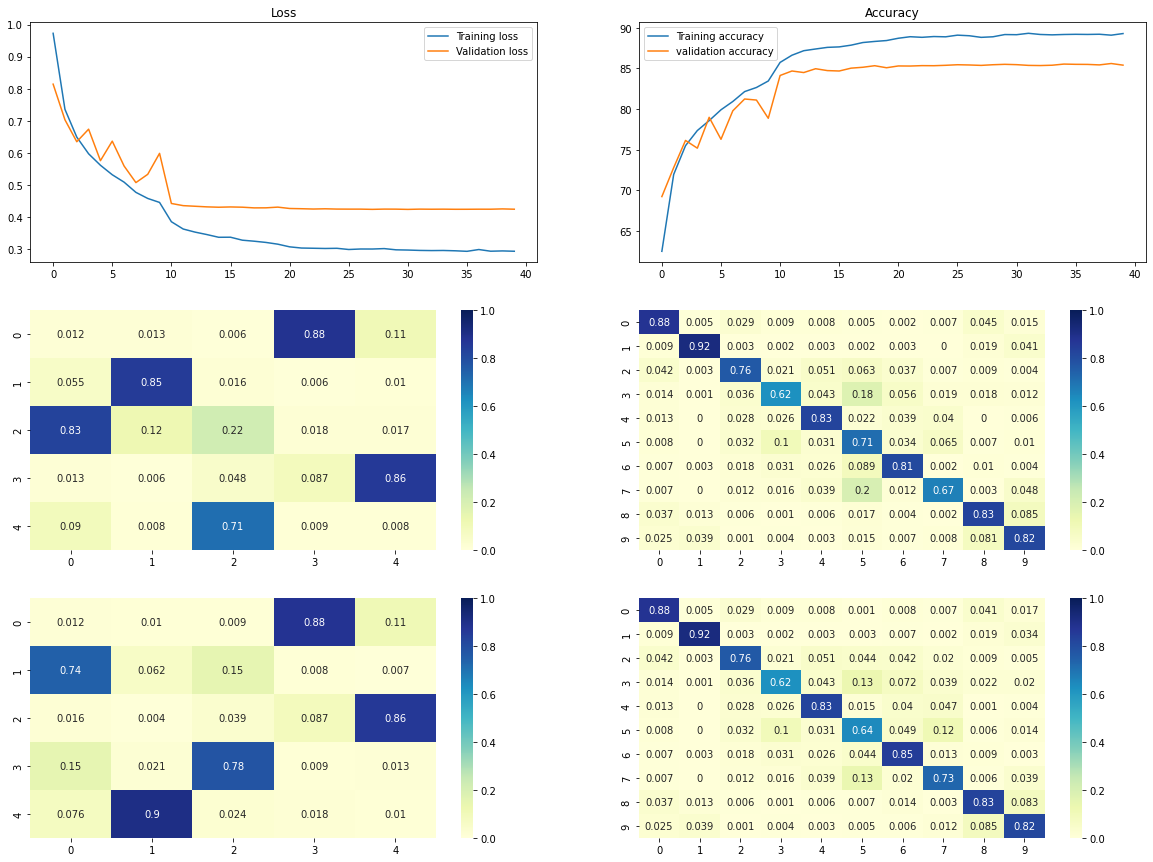

In [19]:
show_result(tr_loss, val_loss, tr_acc, val_acc, untrain_mm, whole_mm/1000, multi_untrain_mm, multi_whole_mm/1000)

#### Experiment II: 4 classes was hidden

In [ ]:
NUM_CLASS = 10
NUM_UNTARGET_CLASS = 4
EPOCHS = 30
REPLACE_LST = [6,7,8,9]
tr_loss, val_loss, tr_acc, val_acc, model, scattering, replace, unlabel_features_test, unlabel_features_training, grand_truth_training, grand_truth_test, test_set = stage1_train()

In [35]:
untrain_mm, whole_mm, multi_untrain_mm, multi_whole_mm = stage2_train(model, test_set, scattering, replace)

100%|██████████| 10/10 [02:54<00:00, 17.42s/it]


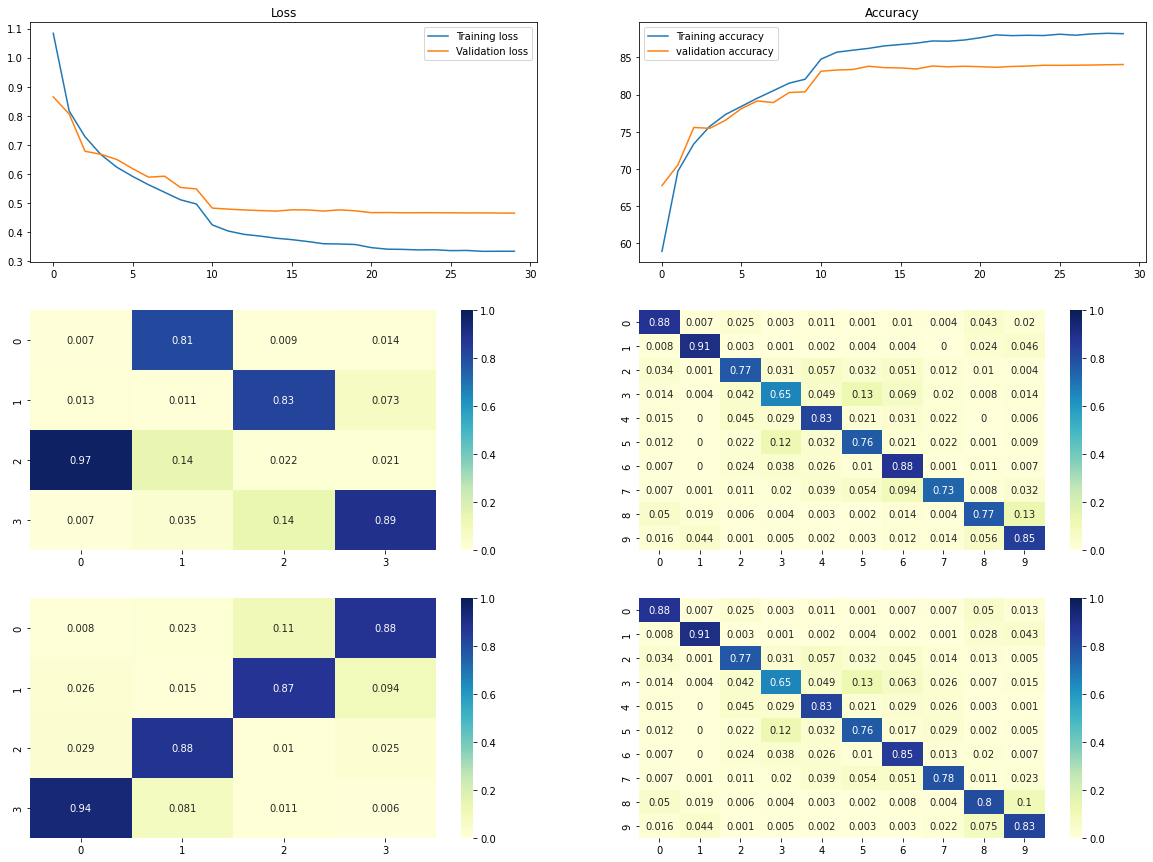

In [22]:
show_result(tr_loss, val_loss, tr_acc, val_acc, untrain_mm, whole_mm/1000, multi_untrain_mm, multi_whole_mm/1000)

#### Experiment III: 3 classes was hidden

In [ ]:
NUM_CLASS = 10
NUM_UNTARGET_CLASS = 3
EPOCHS = 40
REPLACE_LST = [7,8,9]
tr_loss, val_loss, tr_acc, val_acc, model, scattering, replace, unlabel_features_test, unlabel_features_training, grand_truth_training, grand_truth_test, test_set = stage1_train()
    

In [29]:
untrain_mm, whole_mm, multi_untrain_mm, multi_whole_mm = stage2_train(model, test_set, scattering, replace)

100%|██████████| 10/10 [02:14<00:00, 13.42s/it]


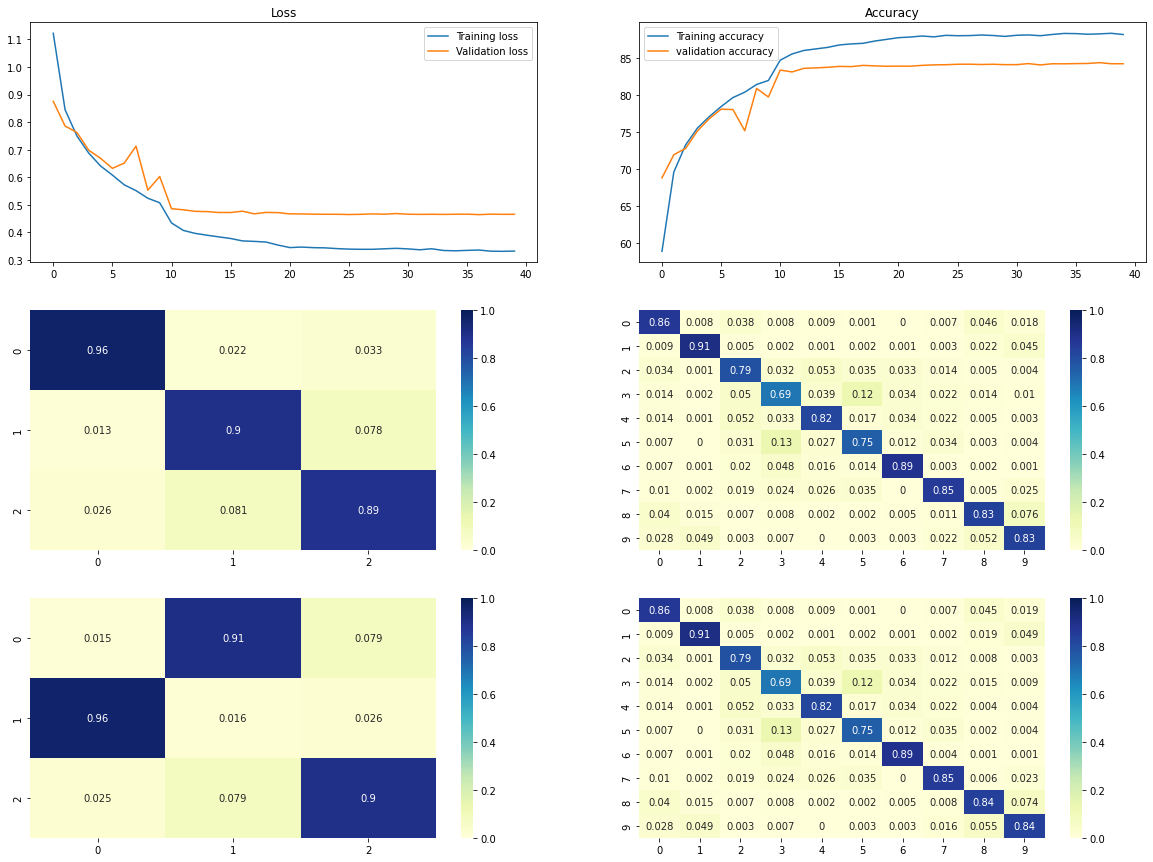

In [30]:
show_result(tr_loss, val_loss, tr_acc, val_acc, untrain_mm, whole_mm/1000, multi_untrain_mm, multi_whole_mm/1000)

### Obeservation:

Our ScatterCNN + GMM network makes fairly well prediction as the average among all the classes for all the experiments are above 80%. We experiment on directly applying GMM to the images but it has a poor accuracy, which infers our scatterCNN does a good job at feature extraction. However we could observe that the accuracy of pretrained-model (ScatterCNN) drops as fewer number of classes is feed in the first stage. Furthermore, different implementation of GMM classifiers in the unsupervised stage don't make huge difference at accuracy.

### Improvement ###

While we are satisfied with the performance of scatter layer, our CNN's structure is too simple, this could be the reason that few classes involved in first stage don't have reasonable accuracy. To solve this problem we could switch our network with ResNet, VGG and other well-known architectures, we also expect that by keeping parameters in those trained models or set a very small learning rate for those models, we could boost our accuracy without spending much more training time by the power of transfer learning. <br>
We assume the issue could also caused by imbalanced classificatoin. I.E the seen classes has a average class size: S, but the unseen group always have a bigger size as it is the combination of 2 or more classes. It leads to the unequal distribution of classes. The easist solution will be resampling our dataset to produce more balanced classes. <br>